<div class="alert alert-block alert-info">
<b>Евгений, привет ! </b> <br> <br>
Спасибо за ревью. <br>
У нас уже идёт мастерская на этой неделе, поэтому я исправил только критические замечания    
</div>

<b>Привет, Леонид!</b>

Меня зовут Евгений Лукашин, я буду проверять твой проект, постараемся вместе сделать его ещё лучше. Предлагаю обращаться к друг другу на «ты», если для тебя это будет комфортно. Иначе дай знать, и мы сразу перейдём на «вы».

Желательно отвечать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку' и т.д.) выделять их каким-либо цветом, например, так:


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Исправил.
</div>


Пожалуйста, не удаляй мои комментарии, так как они повышают качество повторного ревью, и позволят мне быстрее проверить твой проект.

<br>
Мои комментарии будут выглядеть так:

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Если все сделано правильно
</div>

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

Помни, что у нас общая цель - подготовить тебя к успешной работе Data Science  специалистом!

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Времена предсказания и обучения существенны в задаче,   
но из-за нестабильности сервера python Яндекса время обучения сильно колебалось , особенно вечерами,   
поэтому работа выполнена на домашнем PC  

## Подготовка данных

In [1]:
import numpy as np
import re
from datetime import datetime as dt
import timeit as ti
import pandas as pd
import warnings

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer

In [3]:
import lightgbm as lgb

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as plc

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Все импорты принято собирать в одну ячейку

In [5]:
np.random.seed(499)
rmse = lambda y,a: mse(y,a,squared=False)
df = pd.read_csv("/datasets/autos.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Я приведу имена колонок к snake_case, так как привык к этому формату

In [6]:
df.columns  = df.columns.map( lambda string: re.sub(r'(.)([A-Z])',r'\1_\2', string ).lower())
nan_cols = [ c for c in df.columns if df[c].isna().sum()>0 ]
df.head(60)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Здорово, что приводишь названия столбцов к "змеиному" регистру, так их удобней воспринимать и работать, а также это соответствует  <a href="https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html"> PEP 8 </a>.  Также молодец,что умеешь работатть с регулярными выражениями

Посмотрим  колонки с NaN

In [7]:
for c in nan_cols:
    print(f"---- {c} ----- {df[c].isna().sum()} nulls ---- {round(df[c].isna().sum()/df[c].count()*100,1)}% ")
    print(df[c].value_counts().head(10))

---- vehicle_type ----- 37490 nulls ---- 11.8% 
vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64
---- gearbox ----- 19833 nulls ---- 5.9% 
gearbox
manual    268251
auto       66285
Name: count, dtype: int64
---- model ----- 19705 nulls ---- 5.9% 
model
golf        29232
other       24421
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10146
a4           9900
c_klasse     8312
5er          7868
Name: count, dtype: int64
---- fuel_type ----- 32895 nulls ---- 10.2% 
fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64
---- repaired ----- 71154 nulls ---- 25.1% 
repaired
no     247161
yes     36054
Name: count, dtype: int64


<s>Все эти колонки категориальные и пустых значений немного, поэтому их можно заменить на other ,   
тем более что в большинстве этих колонок такое значение уже есть </s>

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> 
Заменять пропущенные зачения заглушкой не всегда может быть эффективным. К тому же если мы заменим все пропуски на other ивыполним в конце EDA (exploratory data analysis - разведочный анализ данных) проверку на дубликаты, то нам придется удалить более трети данных.

Для признаков «VehicleType», «FuelType» пропущенные значения можно заменить, например, модой с группировкой по модели автомобиля и году регистрации - то есть самым часто встречающимся значением для конкретной модели, зарегистрированной в конкретный год. То же самое можно отнести к признаку «Gearbox», у него не очень высокий процент пропущенных значений.
    
С признаками repaired и model сложно что-то прижумать, поэтому их можно/нужно заменять заглушкой
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ОК, исправлю эти колонки по модам
</div>

In [8]:
%%time
df[['repaired','model']] = df[['repaired','model']].fillna('other')
year_cols =['model','registration_year']
fix_nan_cols = ['vehicle_type','fuel_type','gearbox']
modes_by_year =  df.groupby(year_cols)[fix_nan_cols].agg(pd.Series.mode)
modes_by_model =  df.groupby('model')[fix_nan_cols].agg(pd.Series.mode)

def replace_nan_by_mode(row):
    new_values = {}
    for col in fix_nan_cols:
        if isinstance(row[col],str) :
            new_values[col]=row[col]
            continue
        try:
            new_values[col] =  modes_by_year.loc[ tuple( row[year_cols] ),col ]
            if isinstance(new_values[col],str):
                continue
            elif    len(new_values[col]) == 0:
                new_values[col] = modes_by_model.loc[ row['model'],col ]
            elif len(new_values[col])>1:
                new_values[col] = new_values[col][0]       
        except:
            new_values[col] = 'unknown'    
        if len(new_values[col])>1:
            new_values[col] = new_values[col][0]       

    return( new_values )    
    
df[fix_nan_cols] = df.apply(replace_nan_by_mode,axis=1,result_type='expand')

CPU times: total: 1min 21s
Wall time: 1min 32s


Почему-то в этой колонке только нули, во всяком случае в таком виде она бесполезна

In [9]:
df = df.drop('number_of_pictures',axis=1)

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Полностью с тобой согласен

<s>Выделим колонки, где значения уникальны или почти уникальны и посмотрим дубликаты по оставшимся колонкам</s>

In [10]:
# uniq_cols = [ c for c in df.columns if df[c].value_counts().iloc[0]<100 ]  
# non_uniq_cols =  [ c for c in df.columns if df[c].value_counts().iloc[0]>=100 ]
# for c in df.columns:
#     print(c,df[c].value_counts().count(),df[c].value_counts().median())

In [11]:
# df[df[non_uniq_cols].duplicated(keep=False)].sort_values(by=non_uniq_cols )

<s>Похоже это действительно дубликаты с разными датами попадания в базу, я решил удалить их</s> 

In [12]:
# df = df.drop_duplicates(subset=non_uniq_cols)

<s>Колонки с датой важны для обучения, по ним определяется время нахожедения в продаже.  
Проще всего их преобразовать в количество секунд. </s> 

In [13]:
# date_cols = ['date_crawled','date_created','last_seen']
# seconds = lambda s: (dt.strptime(s,'%Y-%m-%d %H:%M:%S')-dt.strptime('1970','%Y')).total_seconds()
# df[date_cols] = df[date_cols].apply(lambda r: list(map(seconds,r)) , result_type='expand')
# df.head()

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> 
Давай еще раз посмотрим на цела работы: "Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля". Т.е. мы заходим в данное приложение и определяем цену автомобиля, тут не будет признаков времени создания объявления или last_seen
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Тогда просто удаляем даты и потом- полные дубликаты
</div>


In [14]:
date_cols = ['date_crawled','date_created','last_seen']
df = df.drop(date_cols,axis=1)
print( df.duplicated().sum( ) )
df = df.drop_duplicates()

22404


Проверим ещё корреляцию

In [15]:
df.corr(numeric_only=True)

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.026678,0.154018,-0.328296,0.109751,0.081010
registration_year,0.026678,1.000000,-0.000745,-0.052515,-0.011159,-0.003086
power,0.154018,-0.000745,1.000000,0.024602,0.042394,0.022191
kilometer,-0.328296,-0.052515,0.024602,1.000000,0.012479,-0.011256
registration_month,0.109751,-0.011159,0.042394,0.012479,1.000000,0.015978
postal_code,0.081010,-0.003086,0.022191,-0.011256,0.015978,1.000000


:<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Здорово, что выполняешь проверку признаков на мультиколлинеарность! Для линейных моделей этот шаг обязателен, но и для других точно не лишний.
</div>

<s>Очень большая корреляция между date_crawled и date_created, одну из них надо удалить</s>

In [16]:
# df = df.drop('date_created',axis= 1)  

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b>

<b>⛔️«Надо исправить»:</b> 
Не хватает обработки аномалий числовых признаков и таргета
</div>

###  Проверка аномалий

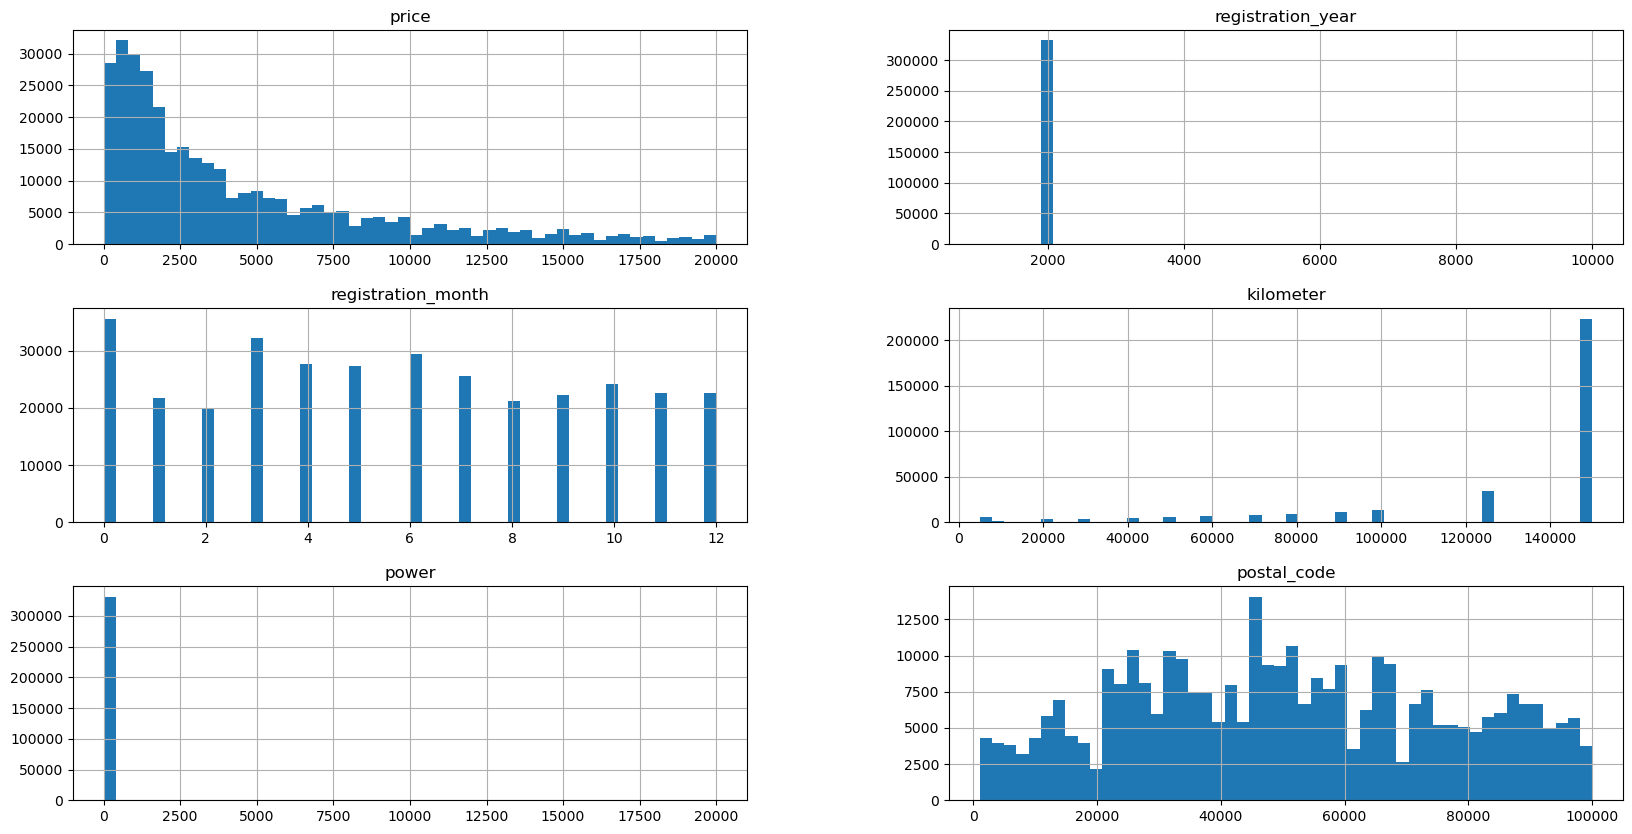

In [17]:
df[['price','registration_year','registration_month','kilometer','power','postal_code']] \
.hist(bins=50,figsize = (20,10) );

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>  На выбросы нало проверить пробег, мощность и дату регистрации<br>
Кроме того , месяц регистсрации точно  содержит нули, цена может содержать нул  
</div>

In [18]:
print(f"Найдено {(df.price<=0).sum()} записей с нулевой ценой или {round(100*(df.price<=0).sum()/df.shape[0],1)} %" )

Найдено 9935 записей с нулевой ценой или 3.0 %


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>  Цена сделки не может быть равна нулю, во всяком случае это не коммерческая сделка и она нам не интересна.<br>
К сожалению, не вижу способа как-то пофиксить , так как строки не содержат никакой информации о целевом признаке и их придется удалить  </br>
Нулевой месяц можно оставить, так как это неопределенное значение все равно надо чем-то заполнять и подходящей замены я не вижу  
</div>


In [19]:
df = df[df.price>0]

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>  Проверим выбросы  по колонке registration_year 
</div>


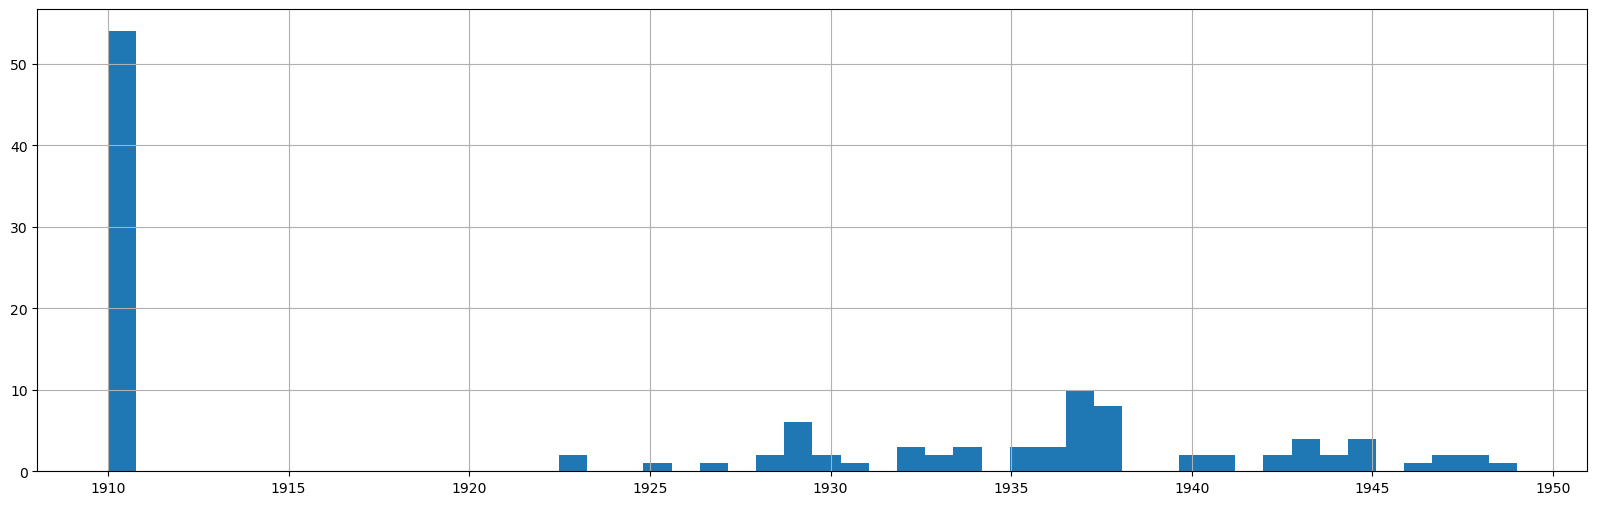

In [20]:
(df[(1900<df.registration_year) & (df.registration_year<1950)]).registration_year.hist(bins= 50 ,figsize= [20,6] );

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> похоже до 1920 еще реальные даты
</div>


In [21]:
print(f"Всего {(df.registration_year>2023).sum()} дат после сегодняшней , из них")
print(f"{((df.registration_year>2023)&(df.registration_month==0)&(df.power==0)).sum()} с нулевой мощностью и месяцем")
print(f"Всего {(df.registration_year<1920).sum()} очень старых дат сегодняшней , из них")
print(f"{((df.registration_year<1920)&(df.registration_month==0)&(df.power==0)).sum()} с нулевой мощностью и месяцем")
df[(df.registration_year>2023)].sort_values(by='registration_year')


Всего 82 дат после сегодняшней , из них
53 с нулевой мощностью и месяцем
Всего 105 очень старых дат сегодняшней , из них
73 с нулевой мощностью и месяцем


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
26560,800,b,2066,m,0,zafira,5000,0,gasoline,opel,other,45355
18259,300,s,2200,m,0,twingo,5000,12,p,renault,other,45307
220638,100,s,2222,m,0,other,5000,0,p,sonstige_autos,other,66538
121506,700,w,2290,m,0,laguna,5000,0,p,renault,other,63069
139756,3500,s,2500,m,0,other,5000,0,gasoline,volkswagen,other,33699
...,...,...,...,...,...,...,...,...,...,...,...,...
217111,850,s,9999,m,0,3er,10000,0,petrol,bmw,no,77746
200525,850,s,9999,m,0,other,10000,0,p,mazda,other,40822
167937,1000,s,9999,m,0,other,10000,0,p,mazda,other,40822
306578,350,s,9999,m,0,kaefer,10000,1,p,volkswagen,other,27432


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>  У большинства записей с неадекватными датами 
   так же нулевой месяц регистрации и аномальная мощность <br>
   Похоже они серьезно испорчены и их всего меньше 0.1%, считаю их лучше удалить <br>
   Остаётся совсем мало записей и так как их мало , их тоже можно удалить <br>
   (Но при реальных предсказаниях нужен такой же контроль входа, иначе можно получить аномальные предсказания? )  
</div>


In [22]:
df = df[ (df.registration_year > 1920) & ((df.registration_year < 2023)) ]

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Осталось проверить аномалии мощности <br>
   Их около 10 % процентов и с ним надо что-то делать, внешне они выглядят как нормальные записи <br>
   Вместо нулевой мощности я предлагаю поставить медиану по модели и году<br>
   Что касается аномалий, не думаю , что есть массовые машины с мощностью ниже 10 л.с и выше 1000 л.с, <br>
   но непонятно, где ставить отсечение  <br>
    Попробуем поймать по гистограмме переход "пуассоновского"(естественного)  в "равномерное" распределение (выбросы ожидаются более равномерно распределенными ) 
</div>


In [23]:
anomal_power_qty = ((df.power<30) | (df.power>1000)).sum()
print(f"Машин с нулевой или аномальной мощностью {anomal_power_qty} или {round(anomal_power_qty/df.shape[0]*100,1)}%")
df[(df.power<30) ].sort_values(by='power',ascending=False) 

Машин с нулевой или аномальной мощностью 35784 или 11.1%


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
122359,14800,convertible,1977,manual,29,other,90000,8,petrol,citroen,no,64395
246580,7500,convertible,1980,manual,29,other,90000,11,petrol,citroen,no,34119
139603,2600,small,1989,manual,29,other,60000,4,petrol,citroen,other,89407
249113,8500,small,1989,manual,29,other,60000,6,petrol,citroen,no,21368
321777,7450,bus,1974,manual,29,other,70000,11,petrol,citroen,no,21335
...,...,...,...,...,...,...,...,...,...,...,...,...
116117,8500,wagon,2011,manual,0,focus,150000,0,petrol,ford,no,21073
116115,2500,bus,2005,manual,0,caddy,150000,0,gasoline,volkswagen,other,15344
116103,2000,coupe,2017,auto,0,3er,150000,3,petrol,bmw,no,31139
116085,4399,suv,2003,manual,0,m_klasse,150000,10,gasoline,mercedes_benz,no,30855


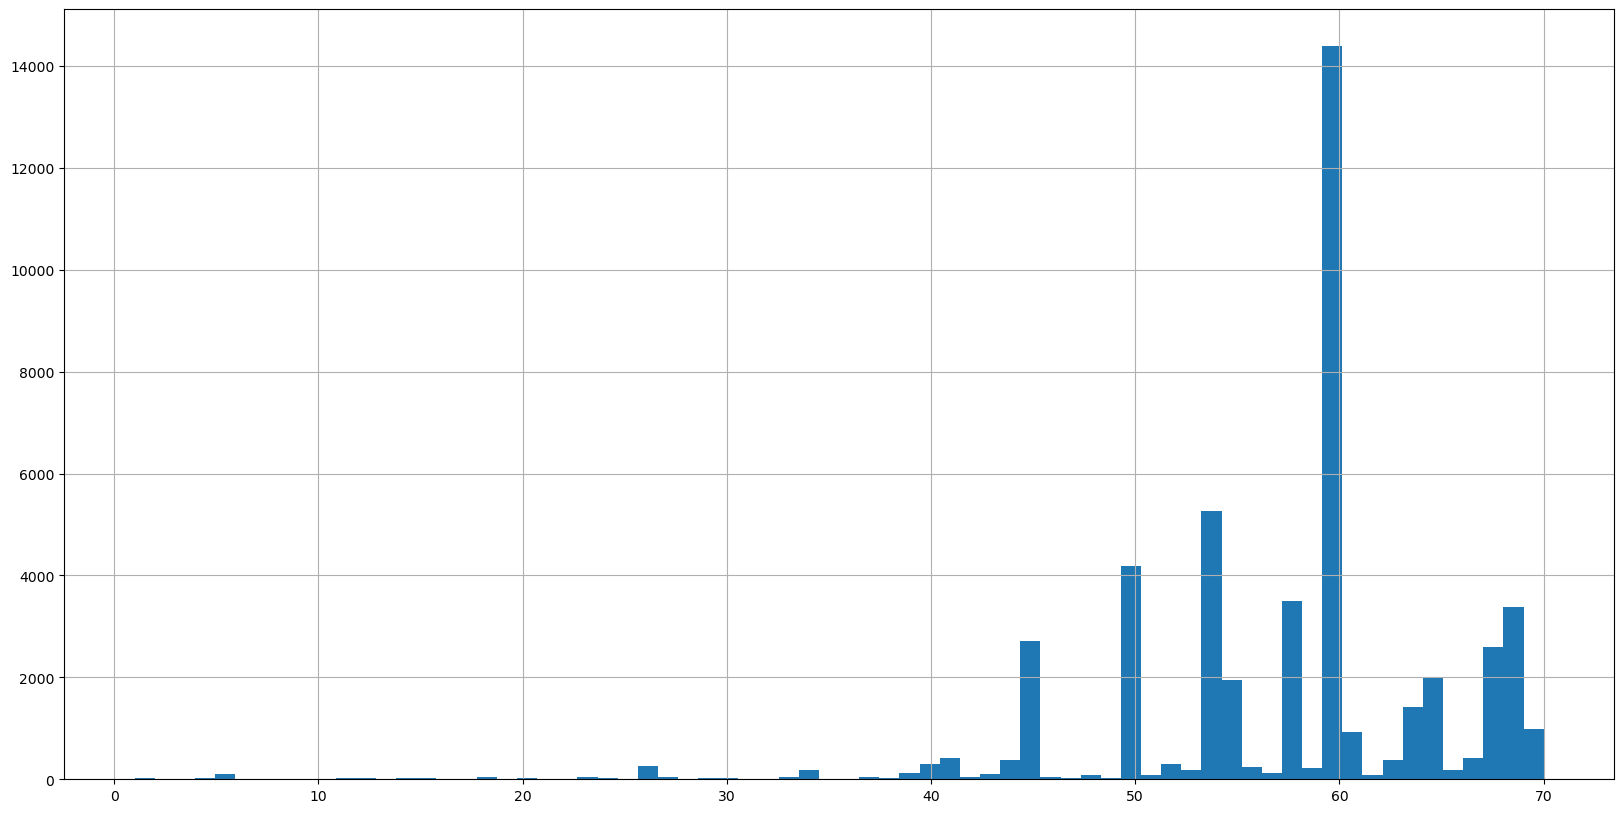

In [24]:
df[(df.power>0) & (df.power<=70)].power.hist(bins=70 , figsize=(20,10)) ;

Для слабых мощностей я предполагаю это ниже 20

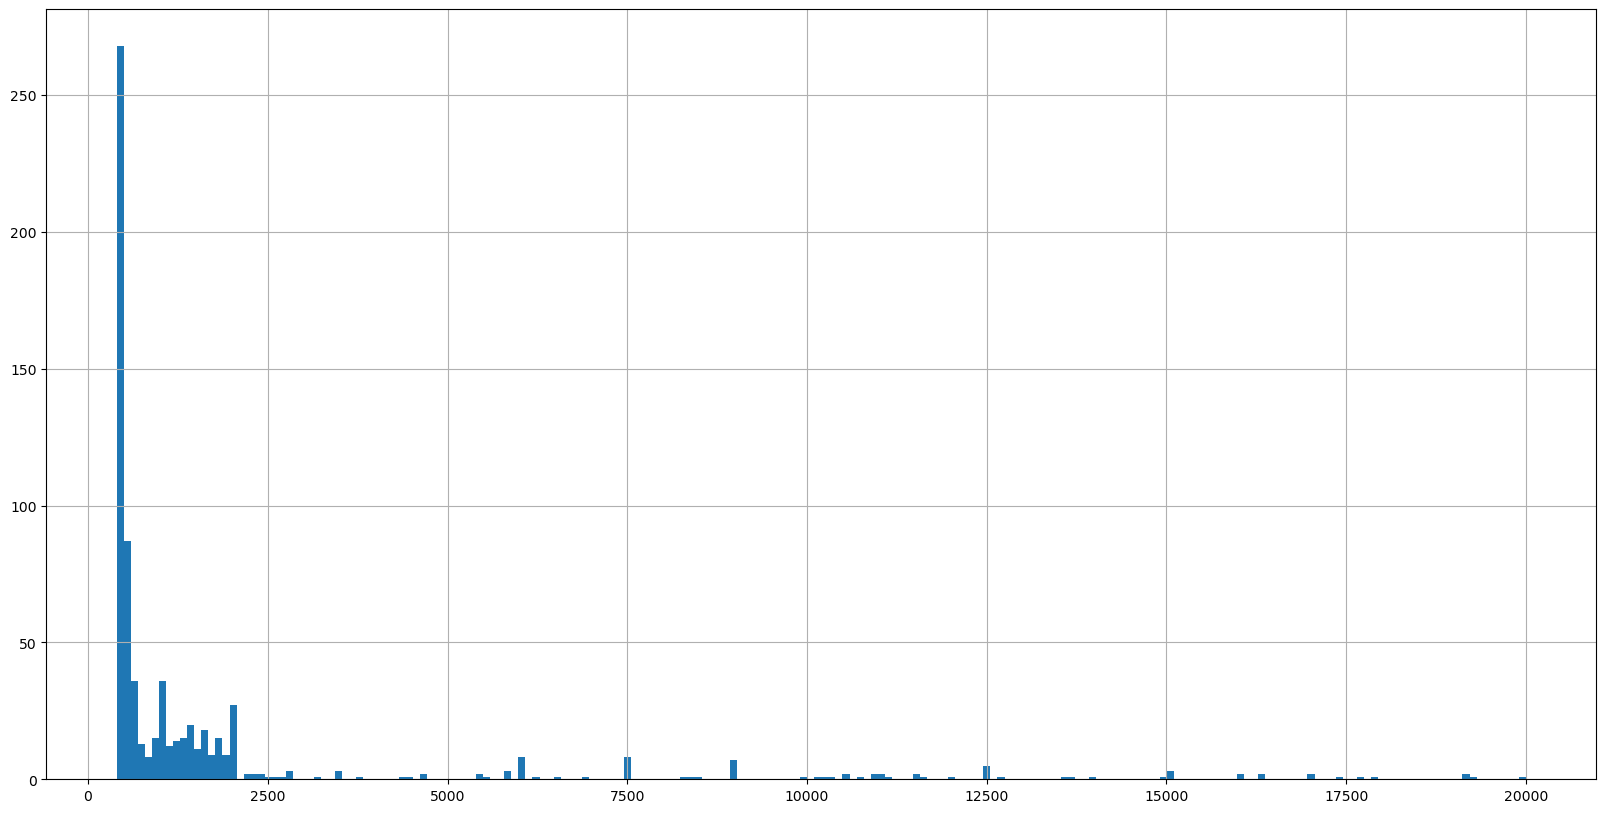

In [25]:
df[ (df.power>=400)].power.hist(bins=200 , figsize=(20,10)) ;

и для сильных выше 700 (на диаграмме шаг 100)

In [26]:
df[['model','registration_year','power']].head(60)

,model,registration_year,power
0,golf,1993,0
1,other,2011,190
2,grand,2004,163
3,golf,2001,75
4,fabia,2008,69
5,3er,1995,102
6,2_reihe,2004,109
8,c_max,2014,125
9,golf,1998,101
10,3_reihe,2004,105


In [27]:
%%time
df.loc[(df.power<20) | (df.power>700),'power']=0
year_cols =['model','registration_year']
medians_by_year =  df.groupby(year_cols)['power'].agg(pd.Series.median)
medians_by_model =  df.groupby('model')['power'].agg(pd.Series.median)
median = df.power.median() 

def replace_zero_by_median(row):
    if row.power > 0:
        return (row.power)
    try:
        new_value =  medians_by_year[ tuple( row[year_cols] )]
        if new_value==0:
            new_value = medians_by_model[ row['model'] ]
        if new_value== 0:
            new_value= median
    except:
         new_value=1    
    return( new_value )    
    
df['power'] = df.apply(replace_zero_by_median,axis=1)
print(f" осталось {((df.power<20) | (df.power>700)).sum()} записей с аномальной мощностью")

 осталось 21 записей с аномальной мощностью
CPU times: total: 26.1 s
Wall time: 27.1 s


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b><br>
    Сбросим аномальные значения в 0 <br>
    и заменим нули медианами
</div>


## Обучение моделей

Определим колонки признаков и цели 

In [29]:
cat_cols = [ c for c in df.columns if df.dtypes[c] == 'object'  ] 
num_cols = [ c for c in df.columns if df.dtypes[c] in ['int64','float' ] ]
target='price'
features = [c for c in num_cols+cat_cols if c != 'price' ]
features

['registration_year',
 'power',
 'kilometer',
 'registration_month',
 'postal_code',
 'vehicle_type',
 'gearbox',
 'model',
 'fuel_type',
 'brand',
 'repaired']

и скопириуем в датафреймы  

In [30]:
for c in cat_cols:
    df[c] = df[c].astype('category')

X = df[features].copy()
y = df[target].copy()

Затем разделим на тренировочный и тестовый наборы с шаффлингом

In [31]:
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size = .25,shuffle=True)

Для исследования обучения и предсказания используется кроссвалидация по тренировочному набору  
Будут проверены все четыре алгоритма , используемые в LightGBM  
Так как их нужно запускать с немного разным набором параметров,
 решетка по каждому алгоримту считается отдельно   
В первую очередь я ищу оптимальное количество оценщиков и скорость обучения 

Для большинства тестов наблюдалось постепенное улучшение метрики при приемлимых временах обучения/предсказания, пока число оценшиков не превысило 500. Так как мне хотелось найти какой-то объективный экстремум, я прогонял тесты вплоть до n_estimators = 1024. При этом время обучения оставалось еще приемлимым, хотя вся поисковая решетка проходила тест больше чем за час.  
<font color="darkblue">Время выполнения оставшейся части блокнота составляет несколько часов</color>

Для ускорения расчет расчет проводится на субсэмплах   
Я считаю, что метрика получится несколько хуже, чем на полном наборе,  
но эта дополнительная ошибка буде более-менее равномерной для разных алгоритмов и гиперпараметров,  
так что можно будет выбрать лучший вариант и провести на нём финальное тестирование

:<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> 
    
    Для ускорения расчет расчет проводится на субсэмплах ... выбрать лучший вариант и провести на нём финальное тестирование

Хороший ход 👍
</div>

### RandomForest   
Как я понимаю, это обычный RandomForest , без градиента  
Ячейка выполняется за ~30 минут

:<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> 
    
Да, так ие есть
</div>

In [32]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['rf'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_rf = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_rf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_rf.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 3.7108e+06
[CV 1/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1919.147, test=-1947.773) total time=   2.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 3.7108e+06
[CV 2/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1925.165, test=-1952.145) total time=   1.5s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not me

[50]	valid_0's l2: 3.69233e+06
[100]	valid_0's l2: 3.66941e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 1/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1908.249, test=-1937.368) total time=   5.4s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.68955e+06
[100]	valid_0's l2: 3.68025e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 2/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1911.282, test=-1939.583) total time=   6.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.7071e+06
[100]	valid_0's l2: 3.67732e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06

[50]	valid_0's l2: 3.69233e+06
[100]	valid_0's l2: 3.66941e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 1/4] END boosting=rf, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1908.249, test=-1937.368) total time=   4.9s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.68955e+06
[100]	valid_0's l2: 3.68025e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 2/4] END boosting=rf, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1911.282, test=-1939.583) total time=   6.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.7071e+06
[100]	valid_0's l2: 3.67732e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[

[50]	valid_0's l2: 3.69233e+06
[100]	valid_0's l2: 3.66941e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 1/4] END boosting=rf, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1908.249, test=-1937.368) total time=   5.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.68955e+06
[100]	valid_0's l2: 3.68025e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 2/4] END boosting=rf, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1911.282, test=-1939.583) total time=   5.4s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.7071e+06
[100]	valid_0's l2: 3.67732e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[

[50]	valid_0's l2: 3.69233e+06
[100]	valid_0's l2: 3.66941e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 1/4] END boosting=rf, learning_rate=0.05, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1908.249, test=-1937.368) total time=   7.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.68955e+06
[100]	valid_0's l2: 3.68025e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 2/4] END boosting=rf, learning_rate=0.05, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1911.282, test=-1939.583) total time=   5.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.7071e+06
[100]	valid_0's l2: 3.67732e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06

[CV 4/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1921.151, test=-1968.408) total time=   1.8s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.69233e+06
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 1/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1913.179, test=-1942.881) total time=   3.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.68955e+06
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 2/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1912.722, te

[CV 3/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1900.066, test=-1969.394) total time=   4.6s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.70503e+06
[100]	valid_0's l2: 3.68529e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 4/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1907.887, test=-1954.754) total time=   4.9s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 1/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1919.147, test=-1947

[50]	valid_0's l2: 3.7071e+06
[100]	valid_0's l2: 3.67732e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 3/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1900.066, test=-1969.394) total time=   4.7s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.70503e+06
[100]	valid_0's l2: 3.68529e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 4/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1907.887, test=-1954.754) total time=   5.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.69233e+06
[100]	valid_0's l2: 3.66941e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06

[50]	valid_0's l2: 3.7071e+06
[100]	valid_0's l2: 3.67732e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 3/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1900.066, test=-1969.394) total time=   4.5s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.70503e+06
[100]	valid_0's l2: 3.68529e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06
[CV 4/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1907.887, test=-1954.754) total time=   4.4s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.69233e+06
[100]	valid_0's l2: 3.66941e+06
Early stopping, best iteration is:
[100]	valid_0's l2: 3.66941e+06

{'boosting': 'rf',
 'learning_rate': 0.3,
 'max_depth': 32,
 'n_estimators': 256,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

:<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> У тебя lgbm сам кодирует категориальные переменные встроенным методом. Это хорошо, потому как, данные кодировщик, как правило, справляется лучше стандартных. LGBM  дефолтно определяет, какие из признаков являются категориальными. Это не всегда работает надежно, поэтому во избежание недопонимания с моделью лучше вручную прописать нуждающиеся в кодировании признаки, для этого есть парметр categorical_feature. Молодец ,что привел категориальные фичи к типу данных category для lgbm это необходимый шаг 

### Gradient Boosting Machine
Дефолтный алгоритм   
<font color="darkblue">Ячейка выполняется за ~90 минут </font>

In [33]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['gbdt'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_def = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_def.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_def.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.5905e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1540.608, test=-1800.441) total time=   1.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.57388e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1539.947, test=-1783.591) total time=   1.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.56622e+06
[CV 3/4] END boosting=

Did not meet early stopping. Best iteration is:
[510]	valid_0's l2: 1.6315e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-829.423, test=-2112.376) total time=  30.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.44305e+06
[100]	valid_0's l2: 2.24275e+06
[150]	valid_0's l2: 2.09683e+06
[200]	valid_0's l2: 1.99958e+06
[250]	valid_0's l2: 1.91151e+06
[300]	valid_0's l2: 1.85291e+06
[350]	valid_0's l2: 1.79375e+06
[400]	valid_0's l2: 1.75451e+06
[450]	valid_0's l2: 1.71054e+06
[500]	valid_0's l2: 1.67674e+06
Did not meet early stopping. Best iteration is:
[510]	valid_0's l2: 1.6315e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-823.984, test=-2154.284) total time=  34.1s
[LightGBM] 

[50]	valid_0's l2: 2.35996e+06
[100]	valid_0's l2: 2.11539e+06
Did not meet early stopping. Best iteration is:
[561]	valid_0's l2: 1.60272e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1281.413, test=-1773.490) total time=   7.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.36701e+06
[100]	valid_0's l2: 2.11621e+06
Did not meet early stopping. Best iteration is:
[561]	valid_0's l2: 1.60272e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1270.466, test=-1798.795) total time=   7.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.37444e+06
[100]	valid_0's l2: 2.12952e+06
Did not meet early stopping. 

[200]	valid_0's l2: 1.82721e+06
[250]	valid_0's l2: 1.73294e+06
[300]	valid_0's l2: 1.65473e+06
[350]	valid_0's l2: 1.59253e+06
[400]	valid_0's l2: 1.54241e+06
[450]	valid_0's l2: 1.49635e+06
[500]	valid_0's l2: 1.45868e+06
[550]	valid_0's l2: 1.42569e+06
[600]	valid_0's l2: 1.39322e+06
[650]	valid_0's l2: 1.36585e+06
[700]	valid_0's l2: 1.34372e+06
[750]	valid_0's l2: 1.32064e+06
[800]	valid_0's l2: 1.3032e+06
[850]	valid_0's l2: 1.28647e+06
[900]	valid_0's l2: 1.27278e+06
[950]	valid_0's l2: 1.25618e+06
[1000]	valid_0's l2: 1.24575e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.22246e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-591.680, test=-1976.538) total time=  59.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.37444e+06
[100]	valid_0's l2: 2.12952e+06
[

[150]	valid_0's l2: 2.05679e+06
[200]	valid_0's l2: 1.93143e+06
[250]	valid_0's l2: 1.82715e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.22246e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1194.453, test=-1729.619) total time=  14.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.49825e+06
[100]	valid_0's l2: 2.22653e+06
[150]	valid_0's l2: 2.05392e+06
[200]	valid_0's l2: 1.92758e+06
[250]	valid_0's l2: 1.82578e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.22246e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1200.099, test=-1713.910) total time=  13.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1935.528, test=-1980.473) total time=   1.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1923.190, test=-1999.718) total time=   1.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_fre

[50]	valid_0's l2: 2.90205e+06
[100]	valid_0's l2: 2.42926e+06
[150]	valid_0's l2: 2.25038e+06
[200]	valid_0's l2: 2.13024e+06
[250]	valid_0's l2: 2.03094e+06
[300]	valid_0's l2: 1.95289e+06
[350]	valid_0's l2: 1.88217e+06
[400]	valid_0's l2: 1.82277e+06
[450]	valid_0's l2: 1.76548e+06
[500]	valid_0's l2: 1.71641e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1154.214, test=-1679.335) total time=  30.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.91133e+06
[100]	valid_0's l2: 2.42842e+06
[150]	valid_0's l2: 2.25594e+06
[200]	valid_0's l2: 2.13205e+06
[250]	valid_0's l2: 2.03346e+06
[300]	valid_0's l2: 1.9503e+06
[350]	valid_0's l2: 1.87909e+06
[400]	valid_0's l2: 1.81557e+06
[450]	valid_0's l2: 1.75934e+06
[50

[50]	valid_0's l2: 3.99133e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1810.529, test=-1880.849) total time=   3.2s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 3.97467e+06
[100]	valid_0's l2: 2.70535e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1561.696, test=-1684.659) total time=   5.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 3.97337e+06
[100]	valid_0's l2: 2.69972e+06
Did not meet early stopping. Best iteration is:
[1024]	valid

[50]	valid_0's l2: 3.97337e+06
[100]	valid_0's l2: 2.69972e+06
[150]	valid_0's l2: 2.44092e+06
[200]	valid_0's l2: 2.30904e+06
[250]	valid_0's l2: 2.21217e+06
[300]	valid_0's l2: 2.13479e+06
[350]	valid_0's l2: 2.0653e+06
[400]	valid_0's l2: 2.00278e+06
[450]	valid_0's l2: 1.9525e+06
[500]	valid_0's l2: 1.90495e+06
[550]	valid_0's l2: 1.85953e+06
[600]	valid_0's l2: 1.81912e+06
[650]	valid_0's l2: 1.77895e+06
[700]	valid_0's l2: 1.74463e+06
[750]	valid_0's l2: 1.71264e+06
[800]	valid_0's l2: 1.68041e+06
[850]	valid_0's l2: 1.65075e+06
[900]	valid_0's l2: 1.62211e+06
[950]	valid_0's l2: 1.59679e+06
[1000]	valid_0's l2: 1.57184e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1087.617, test=-1641.678) total time= 1.0min
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored

[150]	valid_0's l2: 2.68965e+06
[200]	valid_0's l2: 2.49609e+06
[250]	valid_0's l2: 2.38179e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1499.091, test=-1655.480) total time=  13.4s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 5.67212e+06
[100]	valid_0's l2: 3.23207e+06
[150]	valid_0's l2: 2.68634e+06
[200]	valid_0's l2: 2.49066e+06
[250]	valid_0's l2: 2.37547e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1498.232, test=-1649.703) total time=  13.0s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be

[250]	valid_0's l2: 2.38659e+06
[300]	valid_0's l2: 2.30375e+06
[350]	valid_0's l2: 2.23527e+06
[400]	valid_0's l2: 2.17862e+06
[450]	valid_0's l2: 2.12638e+06
[500]	valid_0's l2: 2.07891e+06
[550]	valid_0's l2: 2.03524e+06
[600]	valid_0's l2: 1.99604e+06
[650]	valid_0's l2: 1.95879e+06
[700]	valid_0's l2: 1.9247e+06
[750]	valid_0's l2: 1.89221e+06
[800]	valid_0's l2: 1.85989e+06
[850]	valid_0's l2: 1.83073e+06
[900]	valid_0's l2: 1.8029e+06
[950]	valid_0's l2: 1.77616e+06
[1000]	valid_0's l2: 1.75127e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1193.592, test=-1638.548) total time= 1.1min
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 1/4] END boo

[100]	valid_0's l2: 5.67011e+06
[150]	valid_0's l2: 3.97092e+06
[200]	valid_0's l2: 3.21972e+06
[250]	valid_0's l2: 2.86152e+06
[300]	valid_0's l2: 2.66903e+06
[350]	valid_0's l2: 2.55374e+06
[400]	valid_0's l2: 2.47148e+06
[450]	valid_0's l2: 2.41074e+06
[500]	valid_0's l2: 2.35911e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.1954e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.01, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1490.104, test=-1652.567) total time=  25.2s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 9.81158e+06
[100]	valid_0's l2: 5.69324e+06
[150]	valid_0's l2: 3.98432e+06
[200]	valid_0's l2: 3.22973e+06
[250]	valid_0's l2: 2.8686e+06
[300]	valid_0's l2: 2.67299e+06
[350]	valid_0's l2: 2.55493e+06
[400]	valid_0's l2: 2.47165e+06
[450]	valid_0's l2: 2.40938e+06
[500]	valid_0's l2: 2.35947e+06
Di

{'boosting': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 32,
 'n_estimators': 1024,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

### Gradient base one-sample
При попытке определить subset процесс падает, как я понимаю из-за того, что поднаборы интенсивно использутся внутри  goss  
<font color="darkblue">Ячейка выполняется за ~90 минут </font>

In [34]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['goss'],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_goss= GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_goss.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_goss.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.0458e+06
[CV 1/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1332.717, test=-1689.611) total time=   1.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.0458e+06
[CV 2/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1336.463, test=-1688.222) total time=   2.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.0458e+06
[CV 3/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511

[150]	valid_0's l2: 1.46356e+06
[200]	valid_0's l2: 1.3699e+06
[250]	valid_0's l2: 1.30487e+06
[300]	valid_0's l2: 1.25619e+06
[350]	valid_0's l2: 1.21846e+06
[400]	valid_0's l2: 1.18742e+06
[450]	valid_0's l2: 1.16304e+06
[500]	valid_0's l2: 1.14225e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's l2: 1.11966e+06
[CV 3/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-583.835, test=-1877.424) total time=  38.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.88172e+06
[100]	valid_0's l2: 1.61184e+06
[150]	valid_0's l2: 1.46633e+06
[200]	valid_0's l2: 1.36985e+06
[250]	valid_0's l2: 1.30316e+06
[300]	valid_0's l2: 1.25365e+06
[350]	valid_0's l2: 1.21495e+06
[400]	valid_0's l2: 1.18387e+06
[450]	valid_0's l2: 1.15965e+06
[500]	valid_0's l2: 1.13917e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's l2: 1.

[50]	valid_0's l2: 1.95168e+06
[100]	valid_0's l2: 1.66441e+06
Did not meet early stopping. Best iteration is:
[866]	valid_0's l2: 1.03562e+06
[CV 3/4] END boosting=goss, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-1058.581, test=-1699.261) total time=   9.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.94109e+06
[100]	valid_0's l2: 1.65774e+06
Did not meet early stopping. Best iteration is:
[866]	valid_0's l2: 1.03562e+06
[CV 4/4] END boosting=goss, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-1058.422, test=-1689.625) total time=   7.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.938e+06
[100]	valid_0's l2: 1.65375e+06
[150]	valid_0's l2: 1.48517e+06
[200]	valid_0's l2: 1.37494e+06
[250]	valid_0's l2: 1.29606e+06
Did

[CV 3/4] END boosting=goss, learning_rate=0.2, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2;, score=(train=-441.346, test=-1800.510) total time=  58.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.94109e+06
[100]	valid_0's l2: 1.65774e+06
[150]	valid_0's l2: 1.48896e+06
[200]	valid_0's l2: 1.3776e+06
[250]	valid_0's l2: 1.2968e+06
[300]	valid_0's l2: 1.23672e+06
[350]	valid_0's l2: 1.18791e+06
[400]	valid_0's l2: 1.15003e+06
[450]	valid_0's l2: 1.11809e+06
[500]	valid_0's l2: 1.09186e+06
[550]	valid_0's l2: 1.06867e+06
[600]	valid_0's l2: 1.04939e+06
[650]	valid_0's l2: 1.03187e+06
[700]	valid_0's l2: 1.01749e+06
[750]	valid_0's l2: 1.00494e+06
[800]	valid_0's l2: 992843
[850]	valid_0's l2: 982523
[900]	valid_0's l2: 973095
[950]	valid_0's l2: 964549
[1000]	valid_0's l2: 956769
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 4/4] END boosting=goss, learni

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 1/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-818.036, test=-1663.233) total time=  26.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.16371e+06
[100]	valid_0's l2: 1.86975e+06
[150]	valid_0's l2: 1.69278e+06
[200]	valid_0's l2: 1.56673e+06
[250]	valid_0's l2: 1.47224e+06
[300]	valid_0's l2: 1.39551e+06
[350]	valid_0's l2: 1.33339e+06
[400]	valid_0's l2: 1.28127e+06
[450]	valid_0's l2: 1.236e+06
[500]	valid_0's l2: 1.19707e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 2/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-819.668, test=-1655.949) total time=  29.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current 

[CV 2/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=64, num_leaves=511, objective=l2;, score=(train=-1506.430, test=-1662.459) total time=   4.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.62338e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 3/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=64, num_leaves=511, objective=l2;, score=(train=-1496.522, test=-1692.113) total time=   3.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.62057e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 4/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=64, num_leaves=511, objective=l2;, score=(train=-1501.152, test=-1677.867) total time=   3.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt w

[50]	valid_0's l2: 2.61969e+06
[100]	valid_0's l2: 2.14138e+06
[150]	valid_0's l2: 1.96021e+06
[200]	valid_0's l2: 1.8339e+06
[250]	valid_0's l2: 1.73613e+06
[300]	valid_0's l2: 1.65659e+06
[350]	valid_0's l2: 1.58841e+06
[400]	valid_0's l2: 1.52906e+06
[450]	valid_0's l2: 1.47588e+06
[500]	valid_0's l2: 1.42871e+06
[550]	valid_0's l2: 1.38749e+06
[600]	valid_0's l2: 1.34971e+06
[650]	valid_0's l2: 1.31759e+06
[700]	valid_0's l2: 1.28789e+06
[750]	valid_0's l2: 1.2612e+06
[800]	valid_0's l2: 1.23603e+06
[850]	valid_0's l2: 1.21234e+06
[900]	valid_0's l2: 1.19048e+06
[950]	valid_0's l2: 1.17043e+06
[1000]	valid_0's l2: 1.15188e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 2/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2;, score=(train=-800.437, test=-1627.822) total time=  58.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	val

[250]	valid_0's l2: 1.94896e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 2/4] END boosting=goss, learning_rate=0.03, max_depth=32, n_estimators=256, num_leaves=511, objective=l2;, score=(train=-1311.201, test=-1611.422) total time=  13.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 3.68515e+06
[100]	valid_0's l2: 2.44031e+06
[150]	valid_0's l2: 2.18661e+06
[200]	valid_0's l2: 2.05104e+06
[250]	valid_0's l2: 1.95206e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 3/4] END boosting=goss, learning_rate=0.03, max_depth=32, n_estimators=256, num_leaves=511, objective=l2;, score=(train=-1301.001, test=-1639.835) total time=  12.9s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 3.67773e+06
[100]	valid_0's l2: 2.43822e+06
[150]	valid_0's l2: 2.18687e+06
[200]	

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-2825.660, test=-2842.006) total time=   1.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-2819.512, test=-2859.305) total time=   1.9s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-2818.206, test=-2859.210) total time=   2.2s
[LightGBM] [Warning] boosting is set=goss, boosti

[50]	valid_0's l2: 5.41574e+06
[100]	valid_0's l2: 2.9634e+06
[150]	valid_0's l2: 2.43792e+06
[200]	valid_0's l2: 2.24568e+06
[250]	valid_0's l2: 2.13009e+06
[300]	valid_0's l2: 2.04633e+06
[350]	valid_0's l2: 1.97797e+06
[400]	valid_0's l2: 1.91986e+06
[450]	valid_0's l2: 1.86813e+06
[500]	valid_0's l2: 1.82125e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1239.908, test=-1622.073) total time=  30.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 5.41231e+06
[100]	valid_0's l2: 2.9645e+06
[150]	valid_0's l2: 2.43825e+06
[200]	valid_0's l2: 2.24292e+06
[250]	valid_0's l2: 2.12819e+06
[300]	valid_0's l2: 2.04436e+06
[350]	valid_0's l2: 1.97465e+06
[400]	valid_0's l2: 1.91493e+06
[450]	valid_0's l2: 1.86277e+06
[500]	valid_0's l2: 1.81613e+06
[550]	vali

[50]	valid_0's l2: 9.6087e+06
[100]	valid_0's l2: 5.44415e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 3/4] END boosting=goss, learning_rate=0.01, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-2049.419, test=-2135.369) total time=   6.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 9.60305e+06
[100]	valid_0's l2: 5.44069e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 4/4] END boosting=goss, learning_rate=0.01, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-2051.433, test=-2126.545) total time=   7.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 9.60617e+06
[100]	valid_0's l2: 5.4363e+06
[150]	valid_0's l2: 3.7044e+06
[200]	valid_0's l2: 2.96854e+06
[250]	valid_0's l2: 2.62199e+06
Did not me

[CV 3/4] END boosting=goss, learning_rate=0.01, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2;, score=(train=-1233.791, test=-1629.803) total time=  56.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 9.60305e+06
[100]	valid_0's l2: 5.44069e+06
[150]	valid_0's l2: 3.70686e+06
[200]	valid_0's l2: 2.97121e+06
[250]	valid_0's l2: 2.62604e+06
[300]	valid_0's l2: 2.43899e+06
[350]	valid_0's l2: 2.32427e+06
[400]	valid_0's l2: 2.24291e+06
[450]	valid_0's l2: 2.17974e+06
[500]	valid_0's l2: 2.12737e+06
[550]	valid_0's l2: 2.08248e+06
[600]	valid_0's l2: 2.04262e+06
[650]	valid_0's l2: 2.00639e+06
[700]	valid_0's l2: 1.97311e+06
[750]	valid_0's l2: 1.94195e+06
[800]	valid_0's l2: 1.91364e+06
[850]	valid_0's l2: 1.88723e+06
[900]	valid_0's l2: 1.86144e+06
[950]	valid_0's l2: 1.83702e+06
[1000]	valid_0's l2: 1.81445e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 944604
[CV 4

{'boosting': 'goss',
 'learning_rate': 0.01,
 'max_depth': 32,
 'n_estimators': 1024,
 'num_leaves': 511,
 'objective': 'l2'}

### Dart
<font color="darkblue">Ячейка выполняется за ~150 минут </font>   
Исключил из теста n_estimators = 1024 , так как при этом тест идет слишком долго

In [35]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['dart'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_dart = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_dart.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_dart.best_params_

Fitting 4 folds for each of 35 candidates, totalling 140 fits
[CV 1/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1537.214, test=-1753.837) total time=   1.9s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1542.307, test=-1749.574) total time=   1.9s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 3/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1537.050, test=-1781.210) total time=   1.9s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 4/4]

[500]	valid_0's l2: 1.61141e+06
[CV 4/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1043.538, test=-1772.143) total time= 3.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1560.261, test=-1720.845) total time=   1.7s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1561.620, test=-1717.685) total time=   1.5s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 3/4] END boosting=dart, learning_

[50]	valid_0's l2: 2.62888e+06
[100]	valid_0's l2: 2.33375e+06
[150]	valid_0's l2: 2.20769e+06
[200]	valid_0's l2: 2.06927e+06
[250]	valid_0's l2: 1.97582e+06
[300]	valid_0's l2: 1.89596e+06
[350]	valid_0's l2: 1.84011e+06
[400]	valid_0's l2: 1.7737e+06
[450]	valid_0's l2: 1.71047e+06
[500]	valid_0's l2: 1.66707e+06
[CV 4/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1107.772, test=-1711.742) total time= 3.0min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.1, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1693.368, test=-1774.790) total time=   1.5s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.1, max_depth=32, 

[50]	valid_0's l2: 3.13533e+06
[100]	valid_0's l2: 2.93217e+06
[150]	valid_0's l2: 2.69926e+06
[200]	valid_0's l2: 2.38086e+06
[250]	valid_0's l2: 2.24694e+06
[300]	valid_0's l2: 2.14906e+06
[350]	valid_0's l2: 2.08963e+06
[400]	valid_0's l2: 1.98548e+06
[450]	valid_0's l2: 1.91693e+06
[500]	valid_0's l2: 1.87155e+06
[CV 4/4] END boosting=dart, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1252.061, test=-1648.480) total time= 3.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-2140.084, test=-2167.704) total time=   1.9s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.05, max_depth=3

[CV 3/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1397.597, test=-1673.872) total time= 2.7min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 4.55935e+06
[100]	valid_0's l2: 4.51923e+06
[150]	valid_0's l2: 4.00383e+06
[200]	valid_0's l2: 3.13888e+06
[250]	valid_0's l2: 2.80346e+06
[300]	valid_0's l2: 2.58806e+06
[350]	valid_0's l2: 2.52387e+06
[400]	valid_0's l2: 2.32123e+06
[450]	valid_0's l2: 2.22795e+06
[500]	valid_0's l2: 2.18109e+06
[CV 4/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1404.171, test=-1650.710) total time= 2.8min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.03, max_depth

[50]	valid_0's l2: 6.69995e+06
[100]	valid_0's l2: 6.72429e+06
[150]	valid_0's l2: 6.06112e+06
[200]	valid_0's l2: 4.57896e+06
[250]	valid_0's l2: 3.83243e+06
[300]	valid_0's l2: 3.29438e+06
[350]	valid_0's l2: 3.17652e+06
[400]	valid_0's l2: 2.76383e+06
[450]	valid_0's l2: 2.58994e+06
[500]	valid_0's l2: 2.52098e+06
[CV 3/4] END boosting=dart, learning_rate=0.03, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1524.921, test=-1719.540) total time= 2.7min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 6.71332e+06
[100]	valid_0's l2: 6.7324e+06
[150]	valid_0's l2: 6.06379e+06
[200]	valid_0's l2: 4.56684e+06
[250]	valid_0's l2: 3.82542e+06
[300]	valid_0's l2: 3.29629e+06
[350]	valid_0's l2: 3.16977e+06
[400]	valid_0's l2: 2.75412e+06
[450]	valid_0's l2: 2.58506e+06
[500]	valid_0's l2: 2.51737e+06
[CV 4/4] END boosting=dart, learning_rate=0.03, max

[CV 2/4] END boosting=dart, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1683.204, test=-1783.149) total time= 2.7min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 8.99504e+06
[100]	valid_0's l2: 9.14538e+06
[150]	valid_0's l2: 8.55332e+06
[200]	valid_0's l2: 6.65249e+06
[250]	valid_0's l2: 5.4617e+06
[300]	valid_0's l2: 4.48091e+06
[350]	valid_0's l2: 4.21829e+06
[400]	valid_0's l2: 3.47851e+06
[450]	valid_0's l2: 3.13294e+06
[500]	valid_0's l2: 2.99047e+06
[CV 3/4] END boosting=dart, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1672.119, test=-1815.236) total time= 2.7min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 8.99513e+06
[100]	valid_0's l2: 9.1562e

[50]	valid_0's l2: 1.30586e+07
[100]	valid_0's l2: 1.38728e+07
[150]	valid_0's l2: 1.39023e+07
[200]	valid_0's l2: 1.20422e+07
[250]	valid_0's l2: 1.04347e+07
[300]	valid_0's l2: 8.69889e+06
[350]	valid_0's l2: 8.0599e+06
[400]	valid_0's l2: 6.5179e+06
[450]	valid_0's l2: 5.58388e+06
[500]	valid_0's l2: 5.09065e+06
[CV 2/4] END boosting=dart, learning_rate=0.01, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-2202.977, test=-2240.901) total time= 2.7min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 1.30775e+07
[100]	valid_0's l2: 1.38934e+07
[150]	valid_0's l2: 1.39049e+07
[200]	valid_0's l2: 1.2043e+07
[250]	valid_0's l2: 1.04317e+07
[300]	valid_0's l2: 8.69129e+06
[350]	valid_0's l2: 8.05685e+06
[400]	valid_0's l2: 6.51803e+06
[450]	valid_0's l2: 5.59116e+06
[500]	valid_0's l2: 5.10233e+06
[CV 3/4] END boosting=dart, learning_rate=0.01, max_d

{'boosting': 'dart',
 'learning_rate': 0.1,
 'max_depth': 32,
 'n_estimators': 512,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

### Тест глубины дерева
Тест для оценки влияния параметров глубины дерева и количества листьев, которые должны проверяться совместно
<font color="darkblue">Ячейка выполняется за ~75 минут </font>

In [36]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['goss'],
#     'subsample':[.25],
#     'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.02],
    'n_estimators': [512],
    'max_depth':  [16,32,64,128,256],
    'num_leaves': [255,511,1023,2047]       
}

gbm_tree = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3,
                          scoring='neg_root_mean_squared_error' )
gbm_tree.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['rmse'],callbacks=cbf)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Training until validation scores don't improve for 5 rounds
[50]	valid_0's rmse: 2375.94	valid_0's l2: 5.64507e+06
[100]	valid_0's rmse: 1786.05	valid_0's l2: 3.18997e+06
[150]	valid_0's rmse: 1627.56	valid_0's l2: 2.64895e+06
[200]	valid_0's rmse: 1569.09	valid_0's l2: 2.46205e+06
[250]	valid_0's rmse: 1536.24	valid_0's l2: 2.36004e+06
[300]	valid_0's rmse: 1513.53	valid_0's l2: 2.29079e+06
[350]	valid_0's rmse: 1495.04	valid_0's l2: 2.23514e+06
[400]	valid_0's rmse: 1478.59	valid_0's l2: 2.18622e+06
[450]	valid_0's rmse: 1464.04	valid_0's l2: 2.14341e+06
[500]	valid_0's rmse: 1451.04	valid_0's l2: 2.10551e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1447.95	valid_0's l2: 2.09656e+06
[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=16, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1385.295, test=-1621.455) total time=  15.9s
[LightGBM] [Warning] boosting is set=goss, boo

[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=16, n_estimators=512, num_leaves=1023, objective=l2;, score=(train=-1188.013, test=-1615.112) total time=  28.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2286.64	valid_0's l2: 5.22874e+06
[100]	valid_0's rmse: 1664.93	valid_0's l2: 2.77198e+06
[150]	valid_0's rmse: 1500.43	valid_0's l2: 2.25129e+06
[200]	valid_0's rmse: 1435.29	valid_0's l2: 2.06006e+06
[250]	valid_0's rmse: 1400.71	valid_0's l2: 1.962e+06
[300]	valid_0's rmse: 1377.76	valid_0's l2: 1.89821e+06
[350]	valid_0's rmse: 1358.87	valid_0's l2: 1.84652e+06
[400]	valid_0's rmse: 1341.44	valid_0's l2: 1.79946e+06
[450]	valid_0's rmse: 1325.44	valid_0's l2: 1.75679e+06
[500]	valid_0's rmse: 1310.34	valid_0's l2: 1.71698e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1306.99	valid_0's l2: 1.70823e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=16

[450]	valid_0's rmse: 1458.56	valid_0's l2: 2.1274e+06
[500]	valid_0's rmse: 1444.4	valid_0's l2: 2.08628e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1284.02	valid_0's l2: 1.64872e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1378.031, test=-1615.860) total time=  15.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2377.22	valid_0's l2: 5.65117e+06
[100]	valid_0's rmse: 1788.64	valid_0's l2: 3.19924e+06
[150]	valid_0's rmse: 1629.68	valid_0's l2: 2.65587e+06
[200]	valid_0's rmse: 1570.61	valid_0's l2: 2.46681e+06
[250]	valid_0's rmse: 1536.38	valid_0's l2: 2.36047e+06
[300]	valid_0's rmse: 1511.92	valid_0's l2: 2.2859e+06
[350]	valid_0's rmse: 1491.75	valid_0's l2: 2.22531e+06
[400]	valid_0's rmse: 1474.44	valid_0's l2: 2.17396e+06
[450]	valid_0's rmse: 1458.96	valid_0's l2: 2.12856e+06
[500]	

[250]	valid_0's rmse: 1381.9	valid_0's l2: 1.90964e+06
[300]	valid_0's rmse: 1347.18	valid_0's l2: 1.81489e+06
[350]	valid_0's rmse: 1318.21	valid_0's l2: 1.73768e+06
[400]	valid_0's rmse: 1292.7	valid_0's l2: 1.67107e+06
[450]	valid_0's rmse: 1270.01	valid_0's l2: 1.61292e+06
[500]	valid_0's rmse: 1249.43	valid_0's l2: 1.56108e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1241.61	valid_0's l2: 1.5416e+06
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=1023, objective=l2;, score=(train=-1084.636, test=-1633.679) total time=  34.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2285.34	valid_0's l2: 5.22276e+06
[100]	valid_0's rmse: 1661.44	valid_0's l2: 2.76038e+06
[150]	valid_0's rmse: 1496.04	valid_0's l2: 2.23812e+06
[200]	valid_0's rmse: 1426.49	valid_0's l2: 2.03487e+06
[250]	valid_0's rmse: 1381.04	valid_0's l2: 1.90726e+06
[300]

[50]	valid_0's rmse: 2375.33	valid_0's l2: 5.64217e+06
[100]	valid_0's rmse: 1784.53	valid_0's l2: 3.18456e+06
[150]	valid_0's rmse: 1627.02	valid_0's l2: 2.64719e+06
[200]	valid_0's rmse: 1568.22	valid_0's l2: 2.4593e+06
[250]	valid_0's rmse: 1534.55	valid_0's l2: 2.35485e+06
[300]	valid_0's rmse: 1510.3	valid_0's l2: 2.28102e+06
[350]	valid_0's rmse: 1490.48	valid_0's l2: 2.22153e+06
[400]	valid_0's rmse: 1473.09	valid_0's l2: 2.16998e+06
[450]	valid_0's rmse: 1457.54	valid_0's l2: 2.12441e+06
[500]	valid_0's rmse: 1443.81	valid_0's l2: 2.08459e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1167.6	valid_0's l2: 1.3633e+06
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=64, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1373.261, test=-1626.214) total time=  15.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2326.44	valid_0's l2: 5.41231e+06
[100]	va

[50]	valid_0's rmse: 2251.89	valid_0's l2: 5.071e+06
[100]	valid_0's rmse: 1620.15	valid_0's l2: 2.6249e+06
[150]	valid_0's rmse: 1449.97	valid_0's l2: 2.10241e+06
[200]	valid_0's rmse: 1374.47	valid_0's l2: 1.88916e+06
[250]	valid_0's rmse: 1322.97	valid_0's l2: 1.75024e+06
[300]	valid_0's rmse: 1282.55	valid_0's l2: 1.64494e+06
[350]	valid_0's rmse: 1248.7	valid_0's l2: 1.55926e+06
[400]	valid_0's rmse: 1219.48	valid_0's l2: 1.48713e+06
[450]	valid_0's rmse: 1193.78	valid_0's l2: 1.4251e+06
[500]	valid_0's rmse: 1170.63	valid_0's l2: 1.37037e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1165.57	valid_0's l2: 1.35855e+06
[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=64, n_estimators=512, num_leaves=2047, objective=l2;, score=(train=-966.818, test=-1621.717) total time=  54.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2254.48	valid_0's l2: 5.08269e+06
[100]	val

[50]	valid_0's rmse: 2328.3	valid_0's l2: 5.42097e+06
[100]	valid_0's rmse: 1722.49	valid_0's l2: 2.96696e+06
[150]	valid_0's rmse: 1560.68	valid_0's l2: 2.43572e+06
[200]	valid_0's rmse: 1497.34	valid_0's l2: 2.24204e+06
[250]	valid_0's rmse: 1458.45	valid_0's l2: 2.12707e+06
[300]	valid_0's rmse: 1429.01	valid_0's l2: 2.04206e+06
[350]	valid_0's rmse: 1404.67	valid_0's l2: 1.97311e+06
[400]	valid_0's rmse: 1383.92	valid_0's l2: 1.91524e+06
[450]	valid_0's rmse: 1365.1	valid_0's l2: 1.86349e+06
[500]	valid_0's rmse: 1347.88	valid_0's l2: 1.81679e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1163.82	valid_0's l2: 1.35448e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=128, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1243.822, test=-1607.013) total time=  21.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2327.45	valid_0's l2: 5.41702e+06
[100]

[50]	valid_0's rmse: 2253.99	valid_0's l2: 5.08048e+06
[100]	valid_0's rmse: 1624.4	valid_0's l2: 2.63869e+06
[150]	valid_0's rmse: 1453.44	valid_0's l2: 2.11249e+06
[200]	valid_0's rmse: 1377.93	valid_0's l2: 1.89869e+06
[250]	valid_0's rmse: 1327.19	valid_0's l2: 1.76142e+06
[300]	valid_0's rmse: 1287.12	valid_0's l2: 1.65669e+06
[350]	valid_0's rmse: 1253.45	valid_0's l2: 1.57113e+06
[400]	valid_0's rmse: 1224.32	valid_0's l2: 1.49895e+06
[450]	valid_0's rmse: 1198.61	valid_0's l2: 1.43666e+06
[500]	valid_0's rmse: 1175.65	valid_0's l2: 1.38215e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1163.82	valid_0's l2: 1.35448e+06
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=128, n_estimators=512, num_leaves=2047, objective=l2;, score=(train=-962.579, test=-1643.370) total time=  53.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2253.7	valid_0's l2: 5.07916e+06
[100]

[50]	valid_0's rmse: 2327.18	valid_0's l2: 5.41574e+06
[100]	valid_0's rmse: 1721.45	valid_0's l2: 2.9634e+06
[150]	valid_0's rmse: 1561.38	valid_0's l2: 2.43792e+06
[200]	valid_0's rmse: 1498.56	valid_0's l2: 2.24568e+06
[250]	valid_0's rmse: 1460.32	valid_0's l2: 2.13254e+06
[300]	valid_0's rmse: 1431.12	valid_0's l2: 2.04812e+06
[350]	valid_0's rmse: 1406.49	valid_0's l2: 1.9782e+06
[400]	valid_0's rmse: 1385.5	valid_0's l2: 1.91962e+06
[450]	valid_0's rmse: 1367.04	valid_0's l2: 1.8688e+06
[500]	valid_0's rmse: 1349.33	valid_0's l2: 1.82068e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1163.82	valid_0's l2: 1.35448e+06
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=256, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1240.092, test=-1620.903) total time=  21.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2284.07	valid_0's l2: 5.217e+06
[100]	val

[50]	training's rmse: 2317.12	training's l2: 5.36903e+06
[100]	training's rmse: 1704.69	training's l2: 2.90596e+06
[150]	training's rmse: 1534.85	training's l2: 2.35576e+06
[200]	training's rmse: 1464.83	training's l2: 2.14571e+06
[250]	training's rmse: 1420.01	training's l2: 2.01643e+06
[300]	training's rmse: 1385.22	training's l2: 1.91884e+06
[350]	training's rmse: 1356.27	training's l2: 1.83948e+06
[400]	training's rmse: 1330.69	training's l2: 1.77074e+06
[450]	training's rmse: 1307.22	training's l2: 1.70881e+06
[500]	training's rmse: 1285.95	training's l2: 1.65367e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1163.82	valid_0's l2: 1.35448e+06
CPU times: total: 3h 32min 49s
Wall time: 56min 50s


GridSearchCV(cv=4, estimator=LGBMRegressor(),
             param_grid={'boosting': ['goss'], 'learning_rate': [0.02],
                         'max_depth': [16, 32, 64, 128, 256],
                         'n_estimators': [512],
                         'num_leaves': [255, 511, 1023, 2047],
                         'objective': ['l2']},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=3)

## Анализ моделей

### Класс и функция для  оценивающих графиков   
Результаты теста иллюстрированы двумя графиками, показывающими 
* метрику RMSE и
* время 1.обучения 2.предсказания 
для различных оценщиков и скоростей обучения. Точки, соответствующие одной скорости соединенины линией одного цвета
Для удобства сравнения все графики приведены к одному интервалу и масштабу

In [37]:
class LGDMPlot:
    def __init__(self,gbm,ax,x,y,along,through):
        self.res= gbm.cv_results_
        self.x = x                   # name of scores mean  along X axes , typically time
        self.y = y                   # name of scores mean  along Y axes, typically RMSE  
        self.along = along           # name of parameter promoting along a line, typically n_estimators
        self.through = through       # name of parameter matching one line and promoting across lines,typically learning r
        self.rf = self.create_dataframe()
        self.scale = 4
        self.point_scale = 6
        self.marker='D'
        self.ax = ax
        self.point_size = lambda i,min_size: (np.log2(i)-np.log2(min_size)) * self.point_scale
# point size illustrates amount of estimators        
        self.alpha = lambda i,th_size: .2+(i/th_size)*(1-.25)
# there "alpha" of a line  must hint best results, mathching rank  "i" of best score on the  line
# unfortunately there is a bug and I hasn't found time to fix it yet   
        self.limits = { 'test_score': (1600,2400),'train_score': (1400,1800), 'fit_time':(0,50), 'score_time':(0,15)  }
#  intervals to catch best socres, the same for all tests     
        self.title = f"Dependency of {self.x} and {self.y}  on {self.through } and {self.along}"

    def set_ranks_through(self):
        ranks = self.rf.groupby(self.through)[self.y].max().rank()
        self.rf['rank_through'] = self.rf[self.through].apply(lambda i:ranks[i])        
        
    def create_dataframe(self):
        params = ['n_estimators','learning_rate','max_depth','num_leaves','boosting']
        means = ['fit_time','score_time','train_score','test_score']
        res_cols = list( map( lambda s: 'param_'+s, params))+list( map( lambda s: 'mean_'+s, means) ) 
        f = pd.DataFrame( {k:self.res[k] for k in res_cols} )
        f.columns = params+means  
        f['train_score'] = -f.train_score
        f['test_score'] = -f.test_score
        return f 
    
   # method to pick data for lines  
    def create_batches(self):
        self.set_ranks_through()
       
        batches = []
        th_values = list(sorted(set(self.rf[self.through])))
        self.color =  plc.LinearSegmentedColormap.from_list(' ', ['r','y','g','b','k'], len(th_values))          
        for i in range(len(th_values)):
            val = th_values[i]
            dat = self.rf[self.rf[self.through] ==val ].sort_values(by=self.along)
            dat['s'] = dat[self.along].apply(self.point_size,min_size=dat[self.along].min()-1 )

            batches.append( {'x':dat[self.x],'y':dat[self.y],
                             'c':self.color(i),'z':dat[self.along], 
                             's':dat['s'], 'a': self.alpha(dat.rank_through.iloc[1],len(th_values)),
                             'l':val , 'm': dat[self.along] }  )
            self.size_labels = dat[self.along]
        return(batches)    
        
    def draw(self):
        self.init_plot()
        batches = self.create_batches()
        self.color =  plc.LinearSegmentedColormap.from_list(' ', ['b','r'], len(batches)) 
        for b in batches:
            self.scatter = self.draw_points(b)
            self.line = self.draw_line(b)
        self.draw_legends()
    
    def init_plot(self):
        self.ax.set_title(self.title)
        self.ax.set_xlabel(self.x)
        plt.ylabel(self.y)
        if self.y in self.limits:
            self.ax.set_ylim( self.limits[self.y])
        if self.x in self.limits:
            self.ax.set_xlim( self.limits[self.x])
        
    # draw point as scattered plot 
    def draw_points(self,b):
        return( self.ax.scatter(b['x'],b['y'],color=b['c'],marker=self.marker,s=b['s']) )

    # connect points of the same learning rate for better readability 
    def draw_line(self,b):
        return( self.ax.plot(b['x'],b['y'],color=b['c'],label=b['l'] ,alpha= b['a']) )
    
    def draw_legends(self):
        legend_lines = self.ax.legend(loc='upper right', title = self.through)
        self.ax.add_artist(legend_lines)
        handles,labels = self.scatter.legend_elements(prop='sizes')
        sl = list(self.size_labels.astype(str).values)
        self.ax.legend(handles=handles,labels=sl,loc='upper center',title=self.along)


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Молодец, что владеешь классами 👍

In [38]:
# function to draw a pair of plots for fit/prediction time 
def lgbm_figure(gbm,xs,ys,along,through,figsize=(20,8)):
    fig,axs = plt.subplots(ncols=len(xs), nrows=len(ys), figsize=figsize )  
    for j in range(len(ys)):
        for i in range(len(xs)):
            if (len(xs)==1) & (len(ys)==1):
                ax = axs
            elif  (len(xs)==1) | (len(ys)==1):
                ax = axs[(j+1)*(i+1)-1]
            else:   
                ax = axs[j,i] 
            LGDMPlot(gbm,ax,xs[i],ys[j],along=along,through=through).draw()

### Оценка результатов

В задании мало  сведений о бизнес- процессе, чтобы сделать определённые  предположения о допустимой ошибки и временах предсказаний.  
Я прдполагаю, что цену имеет смысл предсказывать с точность до 100 - примерно так округляются цены продаж и большая тчность будет размыта ошибками из-за такого округления  
Время обучения меньше 8 часов считаю некритичным, так преппологаю, что модель будет переобучаться ночью и оставаться неизменной в течение дня. Скорее время обучения критично для тестов. Конечно , в дальнейшем база данных может быть существенно расширена и требуется как-то оценивать масштабируемость, но пока данных для такой оценки я не вижу. В любом случая, при скоростях обучения в десятки минут здесь остается существенный запас
Предвполагаю что время предсказания больше нескольких секунд уже будет оказывать влияние на бизнес, так как потенциальные клиенты хотят "мгновенные" ответы. Уменьшать это время дальше вряд ли имеет смысл, если только многократное пресказание не используется в каких-то расчетах.  

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b>Да, все верно ,согласен с тобой

### Default gradient boosting

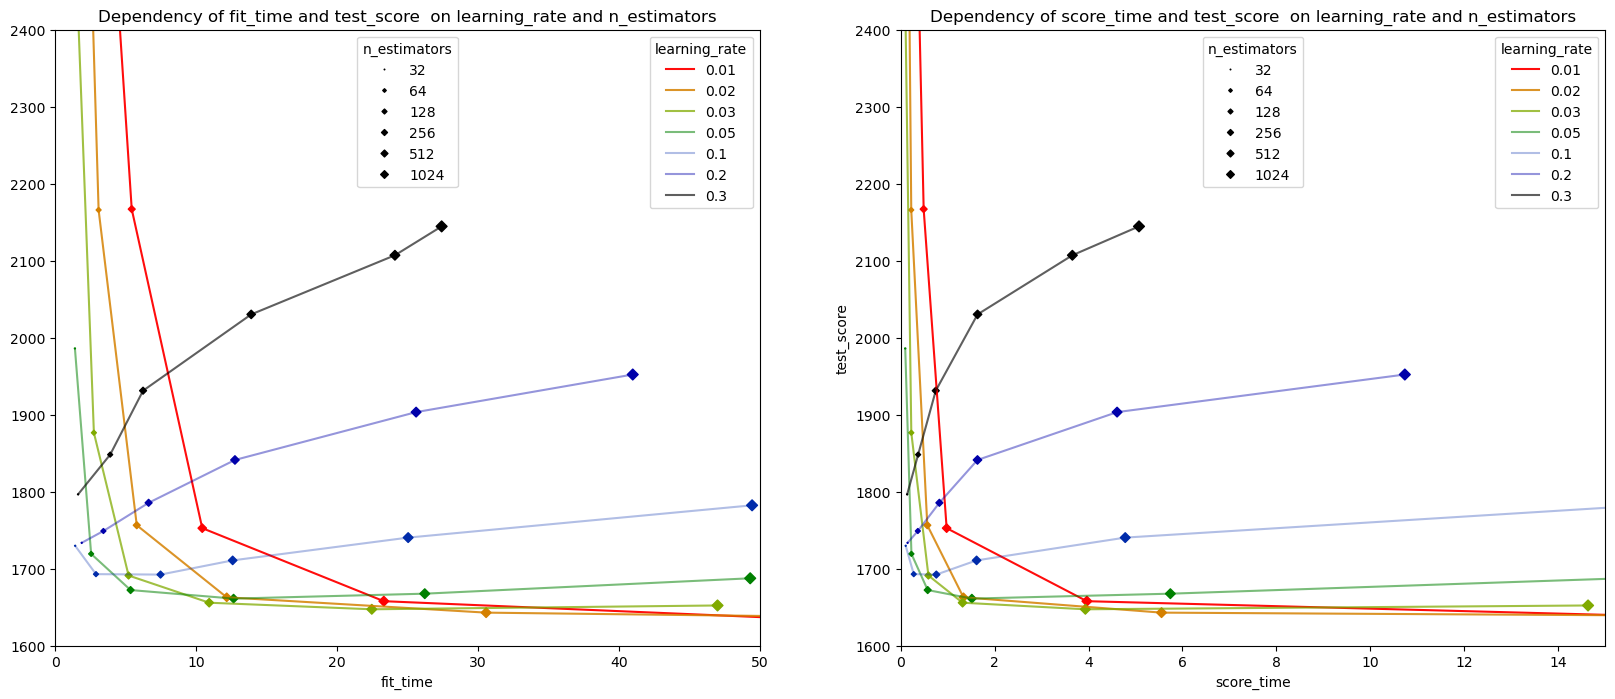

In [39]:
lgbm_figure(gbm_def,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

При скоростях .1 и выше переобучение происходит при небольшом числе оценщиков  и оптимальная метрика не достигается
Скорости 0.01 и ниже видимо позволяют достичь наилучщих метрик, но улучшение ожидается небольшое (<100) в то время как скорости обучения/ предсказания быстро растут
Оптимальны скорости обучения .02-.05

### GOSS

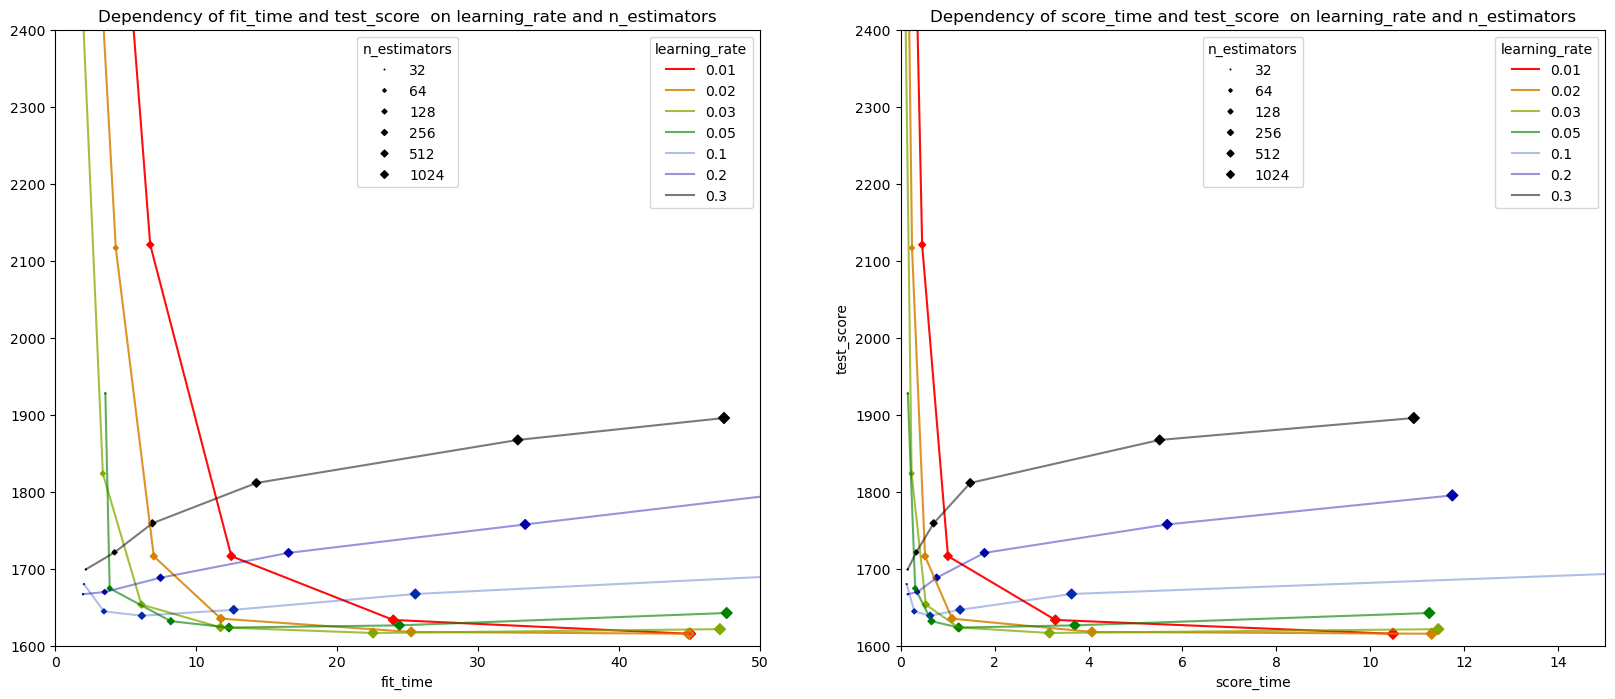

In [40]:
lgbm_figure(gbm_goss,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

Для goss в целом примерно та же картина, но время предсказания несколько меньше
Оптимальными я считаю параметры  learning_rate 0.02-0.05 и n_estimators = 512

### DART

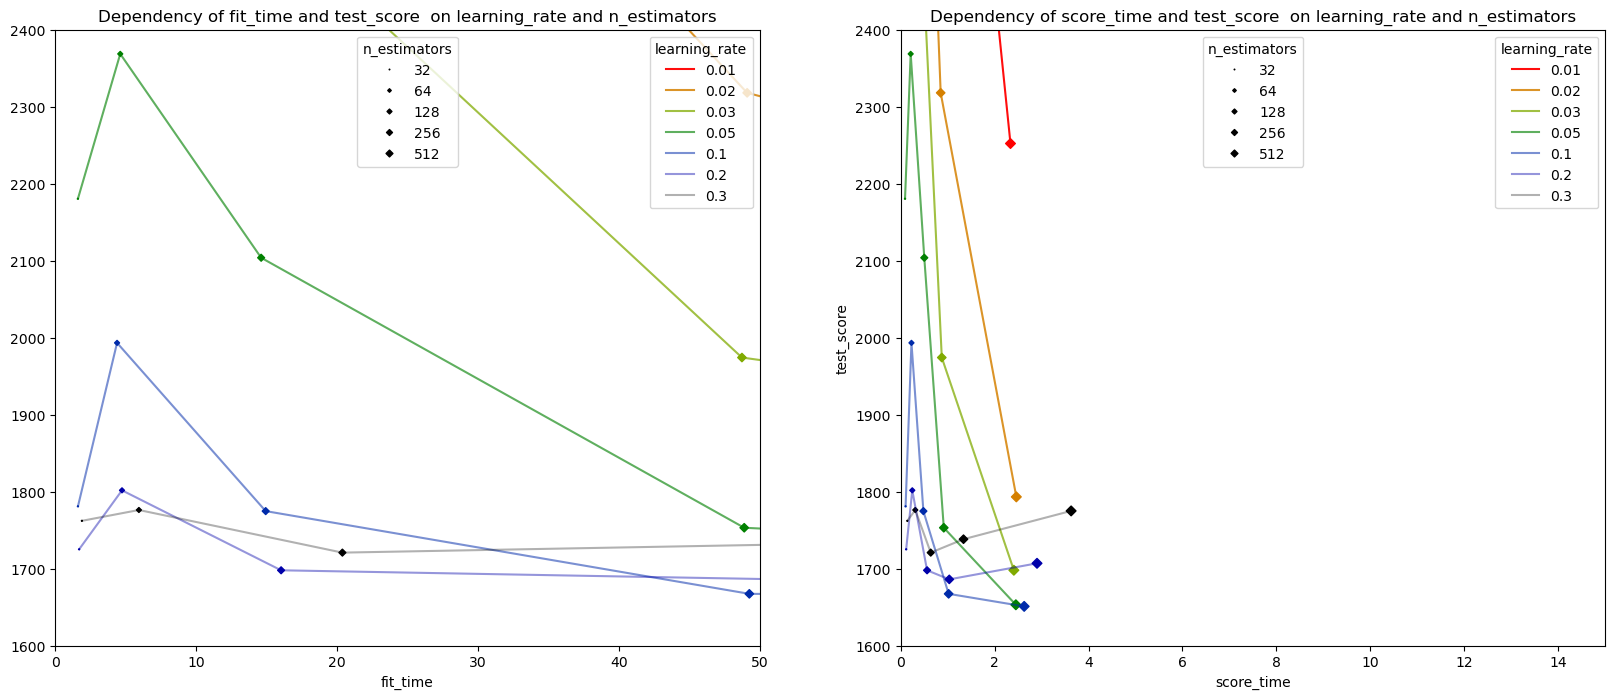

In [41]:
lgbm_figure( gbm_dart,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate' )  

Для darts примерно те же результаты при значительно большем времени обучения.  
Время предсказания внешне выглядит лучше, но только потому, что опущена последняя серия (n_est=1024) из-за очень большого времени обучения 

### Random Forest

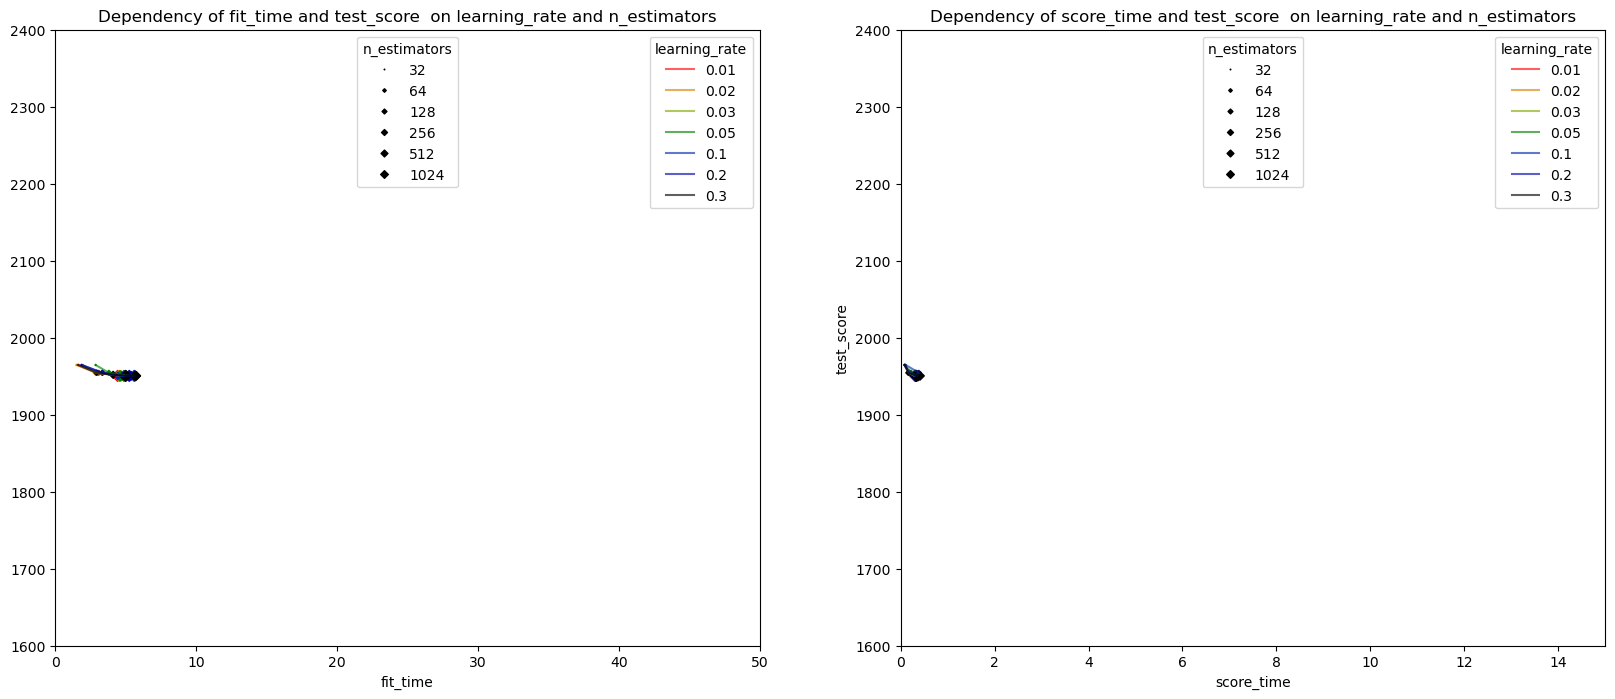

In [42]:
lgbm_figure(gbm_rf,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

При RandomForest результаты получились очень плотные и быстрые, но существенно больше ошибка 

### Структура деревьев

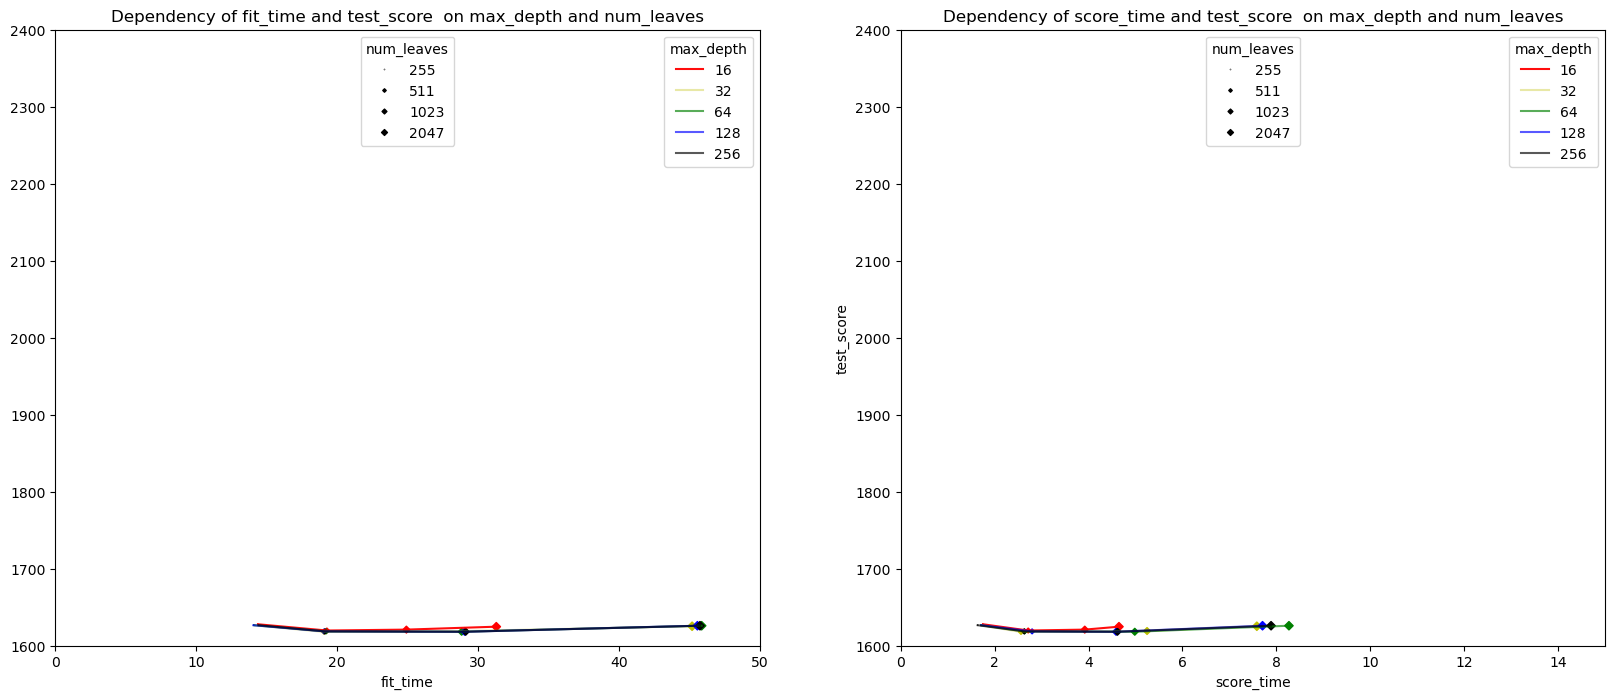

In [43]:
lgbm_figure( gbm_tree,['fit_time','score_time'],['test_score'],along='num_leaves',through='max_depth' )  

Структура дерева практически не влияет на метрику, ну увелечение количества листьев увеличивает время предсказания, по крайней мере для GOSS

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Отлчные информативные графики показывающие зав-ть  RMSE и времени обучения от гиперпараметров

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Было бы здорово, чтобы здесь была таблица отражающая результаты обучения моделей (RMSE, время обучения и предсказания) для наглядного выбора оптимальной модели.

### Final test

In [44]:
%%time
start = ti.default_timer()
model = lgb.LGBMRegressor( boosting='goss',objective='l2',learning_rate='.02',n_estimators = 512 
                              , max_depth=64, num_leaves=255)

model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['rmse'],callbacks=cbf)
step_1 = ti.default_timer()
a = model.predict(X_te)
finish = ti.default_timer()


[50]	training's rmse: 2370.08	training's l2: 5.61729e+06
[100]	training's rmse: 1776.74	training's l2: 3.15679e+06
[150]	training's rmse: 1612.77	training's l2: 2.60102e+06
[200]	training's rmse: 1549.32	training's l2: 2.4004e+06
[250]	training's rmse: 1511.81	training's l2: 2.28558e+06
[300]	training's rmse: 1484.35	training's l2: 2.20328e+06
[350]	training's rmse: 1461.14	training's l2: 2.13492e+06
[400]	training's rmse: 1441.32	training's l2: 2.07741e+06
[450]	training's rmse: 1422.92	training's l2: 2.02469e+06
[500]	training's rmse: 1406.77	training's l2: 1.979e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1163.82	valid_0's l2: 1.35448e+06
CPU times: total: 53.3 s
Wall time: 15.2 s


In [45]:
print(f"R2: {round(r2(y_te,a),4)}\tRMSE: {round(rmse(y_te,a))}")
print(f"Время обучения {round(step_1-start,1)} сек \tвремя предсказания {round(finish-step_1,1)} cек")

R2: 0.8695	RMSE: 1626
Время обучения 12.8 сек 	время предсказания 2.4 cек


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b><br>
После очистки аномалий метрика улучшилась (было RMSE 1647) <br>
Также улучшились времена  (было 15-20 и 3-4 сек )    
</div>


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Тестирование пройдено

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»: </b> Можно проанализировать нашу лучшую модель. Например, вывести график или таблицу важности признаков  <a href="https://newtechaudit.ru/feature-importance-v-sklearn-i-catboost-na-primere-klassicheskih-datasetov/">Feature importances</a>. Также для интерпретации предсказаний моделей есть отличная библотека <a href="https://habr.com/ru/articles/428213/">SHAP</a>.

</div>

### Вывод

При обучении модели предсказания цен рекомендуестся использовать алгоритм GOSS  
с гиперпараметрами - 
n_estimators ~ 500
learning_rate  0.02
num_leaves - до 250
При этом ожидаемая ошибка предсказания - до 1700
время обучения - до 25  с, время предсказания до 5 с


<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>

<b>⚠️«Можно лучше»:</b> Хорошее описание модели, но не хватает развернутого общего вывода по работе. Необходимо написать, что было сделано и к каким результатам это привело, т.е. отразить все важные моменты работы. Есть руководители/заказчики, которые смотрят только введение и вывод.

</div>

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**

Спасибо за твой проект! У тебя хорошая работа! В тебе виден будущий профессионал своего дела!

**Положительные моменты проекта**:
* Прекрасное владение инструментами обработки данных!
* Умелое проведение машинного обучения!
* Все этапы работы проделаны очень осмысленно! Каждый шаг снабжен пояснениями и выводами!
* Работа имеет четкую структуру и выполнена аккуратно, проверять - одно удовольствие!

**Обязательные исправления отмечены красными комментариями, без них, к сожалению, не получится принять работу:**
* Способ заполнения  пропусков
* Обработка аномалий в признаках и таргете
* Удалить неинформативные признаки

**Желаю удачи и жду твой проект на повторное ревью!**😉

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей